In [65]:
from __future__ import unicode_literals, print_function, division
from io import open
import os
import pickle
import unicodedata
import string
import re
import random
import numpy as np
import pandas as pd
import pdb
from tqdm import tqdm
from torch.autograd import Variable


import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [66]:
PAD_idx = 0
SOS_idx = 1
EOS_idx = 2
UNK_idx= 3
batch_size = 64
MAX_SENTENCE_LENGTH = 40

In [67]:
en_pretrained_path = './wiki-news-300d-1M.vec'
zh_pretrained_path = './cc.zh.300.vec'

## Read Data

In [68]:
train_en = open('iwslt-zh-en/train.tok.en' , encoding='utf-8').read().strip().split('\n')
val_en = open('iwslt-zh-en/dev.tok.en', encoding='utf-8').read().strip().split('\n')
test_en = open('iwslt-zh-en/test.tok.en', encoding='utf-8').read().strip().split('\n')
train_en[:5]

['Life in the deep oceans',
 'With vibrant video clips captured by submarines , David Gallo takes us to some of Earth &apos;s darkest , most violent , toxic and beautiful habitats , the valleys and volcanic ridges of the oceans &apos; depths , where life is bizarre , resilient and shockingly abundant .',
 'This is Bill Lange . I &apos;m Dave Gallo .',
 'And we &apos;re going to tell you some stories from the sea here in video .',
 'We &apos;ve got some of the most incredible video of Titanic that &apos;s ever been seen , and we &apos;re not going to show you any of it .']

In [69]:
print(len(train_en), len(val_en), len(test_en))

213376 1261 1397


In [70]:
train_zh = open('iwslt-zh-en/train.tok.zh', encoding='utf-8').read().strip().split('\n')
val_zh = open('iwslt-zh-en/dev.tok.zh', encoding='utf-8').read().strip().split('\n')
test_zh = open('iwslt-zh-en/test.tok.zh', encoding='utf-8').read().strip().split('\n')


In [71]:
train_zh[0].split()

['深海', '海中', '的', '生命', '大卫', '盖罗']

In [72]:
def to_dataframe(en, ch, len_raio=0.95):
    en_len_list, ch_len_list = [], []
    for en_sample, ch_sample in zip(en, ch):
        en_len_list.append(len(en_sample))
        ch_len_list.append(len(ch_sample))
    df = pd.DataFrame({'en': en, 
                       'en_len': en_len_list,
                       'ch': ch,
                       'ch_len': ch_len_list
                      })
    en_len_at_ratio = sorted(en_len_list)[int(len_raio*len(en_len_list))]
    ch_len_at_ratio = sorted(ch_len_list)[int(len_raio*len(ch_len_list))]
    print ("EN length @{}: {}, CH length @{}: {}".format(len_raio, en_len_at_ratio, len_raio, ch_len_at_ratio))
    return df, max(en_len_at_ratio, ch_len_at_ratio)

## Data Preprocessing 



load pre-trained embedding and create the index2words

In [73]:
def load_vectors(fname):
    """
    load the pretrained word embeddings
    param fname: the path the to the word embedding
    return: 
            a dictionary of the {word: embedding}
    """
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

In [74]:
# Get the vocabulary based on the training data
from collections import Counter

def get_vocabulary(data, VOCABULARY_SIZE=30000):
    
    en_vocab, ch_vocab = [], []
    for idx, row in data.iterrows():
        en_vocab += row['en'].split()
        ch_vocab += row['ch'].split()
    en_token_counter = Counter(en_vocab)
    ch_token_counter = Counter(ch_vocab)
    print ("Number of en words: {}, ch words: {}".format(len(en_token_counter), len(ch_token_counter)))
    en_word, _ = zip(*en_token_counter.most_common(VOCABULARY_SIZE))
    en_id2token = ['<PAD>','<SOS>','<EOS>','<UNK>'] + list(en_word)
    en_token2id = dict(zip(en_id2token, np.arange(len(en_id2token))))
    ch_word, _ = zip(*ch_token_counter.most_common(VOCABULARY_SIZE))
    ch_id2token = ['<PAD>','<SOS>','<EOS>','<UNK>'] + list(ch_word)
    ch_token2id = dict(zip(ch_id2token, np.arange(len(ch_id2token))))
    return en_id2token, en_token2id, ch_id2token, ch_token2id

In [75]:
def get_embedding_weights(whole_vec, id2token):
    """
    get the embeddings based on the word, create the embedding matrix
    param whole_vec: the dictionary of pretrained embeddings
    param id2token: the whole vocabulary
    return:
            embedding matrix
    """
    weight = np.zeros((len(id2token), len(whole_vec['sky'])))
    mask = np.zeros((len(id2token)))
    for i, word in enumerate(id2token[1:]):
        if i<3:
            weight[i+1] = np.array(np.random.randn(300))
        elif word in whole_vec.keys():
            weight[i+1] = np.array(whole_vec[word])
        else:
            weight[i+1] = weight[3]
            mask[i+1] = 1
            print ("Out of vocabulary word: ", word)   
    return weight, mask

In [76]:
def load_pickle(data_path, callback, *callback_args):
    """
    Create huge file with the callback function if not exist, otherwise load directly
    param data_path: the path of the load file if exist, otherwise the path to store the created file
    param callback: the function to generate the data if not exist
    param callback_args: the argument for the callback:
    return: 
            the data, either loaded or created by callback
    """

    data_path = data_path
    if os.path.isfile(data_path):
        print ('File exists, load from path...')
        data = pickle.load(open(data_path, 'rb'))
    else:
        print ('File not exists, creating...')
        data = callback(*callback_args)
        pickle.dump(data, open(data_path, 'wb'))
    return data

In [77]:
eng_pretrained = load_pickle('en_pretrained.pkl', load_vectors, en_pretrained_path)
zh_pretrained = load_pickle('zh_pretrained.pkl', load_vectors, zh_pretrained_path)

File exists, load from path...
File exists, load from path...


Normalize english sentences

In [78]:
#Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s =' '.join([word.replace('&apos',' ') for word in s.split()])
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def normalizeZh(s):
    s = s.strip()
    s = re.sub( '\s+', ' ', s )
    return s

def reverseZh(s):
    s= s.split(' ')[::-1]
    return ' '.join(s)


Token to index function

In [79]:
def token_to_index(sentence, token2id):
    indicies_data = []
    for s in sentence:
        tokens = s.split(' ')
        index_list =[token2id[token] if token in token2id else UNK_idx for token in tokens]
        assert len(tokens) == len(index_list)
        indicies_data.append(index_list)
    return indicies_data


** English**


In [80]:
normalize_train_en = [normalizeString(s) for s in train_en]
normalize_val_en = [normalizeString(s) for s in val_en]
normalize_test_en = [normalizeString(s) for s in test_en]
normalize_train_en[:5]

['life in the deep oceans',
 'with vibrant video clips captured by submarines david gallo takes us to some of earth s darkest most violent toxic and beautiful habitats the valleys and volcanic ridges of the oceans depths where life is bizarre resilient and shockingly abundant .',
 'this is bill lange . i m dave gallo .',
 'and we re going to tell you some stories from the sea here in video .',
 'we ve got some of the most incredible video of titanic that s ever been seen and we re not going to show you any of it .']

** Chinese**

In [81]:
normalize_train_zh = [normalizeZh(s) for s in train_zh]
normalize_val_zh = [normalizeZh(s) for s in val_zh]
normalize_test_zh = [normalizeZh(s) for s in test_zh]
normalize_train_zh[0]

'深海 海中 的 生命 大卫 盖罗'

In [82]:
train_df, pad_len = to_dataframe(normalize_train_en, normalize_train_zh)
val_df, _ = to_dataframe(normalize_val_en, normalize_val_zh)
test_df, _ = to_dataframe(normalize_test_en, normalize_test_zh)

EN length @0.95: 230, CH length @0.95: 122
EN length @0.95: 242, CH length @0.95: 131
EN length @0.95: 187, CH length @0.95: 94


In [83]:
en_id2token, en_token2id, zh_id2token, zh_token2id = get_vocabulary(train_df)

Number of en words: 50964, ch words: 88914


In [84]:
train_en_indicies = token_to_index(normalize_train_en, en_token2id)
val_en_indicies = token_to_index(normalize_val_en, en_token2id)
test_en_indicies = token_to_index(normalize_test_en, en_token2id)

In [85]:
train_zh_indicies = token_to_index(normalize_train_zh, zh_token2id)
val_zh_indicies = token_to_index(normalize_val_zh, zh_token2id)
test_zh_indicies = token_to_index(normalize_test_zh, zh_token2id)

In [86]:
normalize_train_zh =[reverseZh(s) for s in normalize_train_zh]
normalize_val_zh =[reverseZh(s) for s in normalize_val_zh]
normalize_test_zh =[reverseZh(s) for s in normalize_test_zh]

In [87]:
print ('-'*100)
eng_embedding, _ = load_pickle('eng_embedding_3.pkl', get_embedding_weights, eng_pretrained, en_id2token)

print ('-'*100)
zh_embedding, _ = load_pickle('zh_embedding_3.pkl', get_embedding_weights, zh_pretrained, zh_id2token)

----------------------------------------------------------------------------------------------------
File exists, load from path...
----------------------------------------------------------------------------------------------------
File exists, load from path...


## DataLoader

In [88]:
class LanguageDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, source_lan, translate_lan):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.source_lan = source_lan
        self.translate_lan = translate_lan
        
        assert (len(self.source_lan) == len(self.translate_lan))

    def __len__(self):
        return len(self.source_lan)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        source_lan_idx = self.source_lan[key][:MAX_SENTENCE_LENGTH-1]
        translation_lan_idx = self.translate_lan[key][:MAX_SENTENCE_LENGTH-1]
        source_lan_idx.append(EOS_idx)
        translation_lan_idx.append(EOS_idx)
        
        return [source_lan_idx, translation_lan_idx, len(source_lan_idx), len(translation_lan_idx)]


In [89]:
def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    source_list = []
    translate_list = []
    #s_length_list = []
    t_length_list = []
    
    # padding
    for datum in batch:

        #s_length_list.append(datum[2])
        t_length_list.append(datum[3])
        s_padded_vec = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])),
                                mode="constant", constant_values=PAD_idx)
        source_list.append(s_padded_vec)
        t_padded_vec = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])),
                                mode="constant", constant_values=PAD_idx)
        translate_list.append(t_padded_vec)
        
    ind_dec_order = np.argsort(t_length_list)[::-1]
    source_list = np.array(source_list)[ind_dec_order]
    t_length_list = np.array(t_length_list)[ind_dec_order]
    translate_list = np.array(translate_list)[ind_dec_order]
    
    if torch.cuda.is_available and torch.has_cudnn:
        return [torch.from_numpy(np.array(source_list)).cuda(),torch.from_numpy(np.array(translate_list)).cuda()]
    
    else:
        return [torch.from_numpy(np.array(source_list)),torch.from_numpy(np.array(translate_list))]



In [90]:
# Build train, valid and test dataloaders

train_dataset = LanguageDataset(train_zh_indicies, train_en_indicies)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = LanguageDataset(val_zh_indicies, val_en_indicies )
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

test_dataset = LanguageDataset(test_zh_indicies, test_en_indicies)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)


## Rnn Encoder

In [54]:
class EncoderRNN(nn.Module):
    def __init__(self, emb_dim, hid_dim):
        super(EncoderRNN, self).__init__()
        
        self.hid_dim = hid_dim
        
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(zh_embedding), freeze=False)
        
        self.dropout = nn.Dropout(p=0.3)
        self.gru = nn.GRU(emb_dim, self.hid_dim, batch_first=True, bidirectional= True)
        

    def forward(self, inputs, hidden):
        batch_size, length = inputs.size()
        embedded = self.dropout(self.embedding(inputs).float()) # the size -1 is inferred from other dimensions
        
        hidden = torch.cat((hidden, hidden))
        encoder_out, hidden = self.gru(embedded, hidden)
        hidden = self._cat_directions(hidden)

        return hidden
    def _cat_directions(self, hidden):
       
        def _cat(h):
            return torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], 2)
            
        # GRU hidden
        hidden = _cat(hidden)
            
        return hidden

    def init_hidden(self, batch_size):
        
        return torch.rand(1, batch_size, self.hid_dim, device=device)

## Decoder w/o Attention

In [55]:
class DecoderRNN(nn.Module):
    def __init__(self, emb_dim, hid_dim, output_dim):
        super(DecoderRNN, self).__init__()
        
        self.hid_dim = hid_dim *2
        self.output_dim = output_dim
        self.dropout = nn.Dropout(p=0.3)
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(eng_embedding), freeze=True)
        self.gru = nn.GRU(emb_dim + self.hid_dim, self.hid_dim)
        self.out = nn.Linear(self.hid_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs, hidden, context):
        #input = [1, batch size]
        #hidden = [1, batch size, hid dim]
        #context = [batch size, sen len, hid dim]
        emb = self.dropout(self.embedding(inputs).float())
        emb_con = torch.cat((emb, context), dim=2)
        #emb_con =[1, batch_size, emb dim+ hid dim]
        emb_con = F.relu(emb_con)
        output, hidden = self.gru(emb_con, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

In [56]:
teacher_forcing_ratio = 1
#input_tensor: list of sentence tensor
def train(source, translate, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion):
    
    batch_size, input_length = source.size()
    batch_size, target_length = translate.size()
    encoder_hidden = encoder.init_hidden(batch_size)
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    #hidden = [1, batch size, hid dim]
    #encoder_output = [batch size, sen len, hid dim]
    encoder_hidden = encoder(source, encoder_hidden)
    decoder_input = torch.tensor(np.array([[SOS_idx]]*batch_size).reshape(1,batch_size),device=device)
    decoder_hidden = encoder_hidden
    #last hidden state of the encoder is the context
    context = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for i in range(target_length):
            #decoder_input: previous output of decoder
            #decoder_hidden: previous hidden state of decoder
            #encoder_output: last hidden layer of encoder
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, context)
            loss += criterion(decoder_output, translate[:,i])
            decoder_input = translate[:,i].unsqueeze(0)  # Teacher forcing
            
    else:
        # Without teacher forcing: use its own predictions as the next input
        for i in range(target_length):
            decoder_output, decoder_hidden= decoder(decoder_input, decoder_hidden, context)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            #decoder_input [1, batch size] 
            decoder_input = decoder_input.unsqueeze(0)
            loss += criterion(decoder_output, translate[:,i])

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length



In [58]:
import sacrebleu
def evaluate2(encoder, decoder, loader):
    encoder.eval()
    decoder.eval()
    input_words = []
    target_words = []
    decoded_words = []
    num_count = 0
    num_count = 0
    for i, (source, translate) in enumerate(loader):
        cur_batch_size = translate.size()[0] 
        with torch.no_grad():
            encoder_hidden = encoder.init_hidden(cur_batch_size)
        input_tensor = source
        target_tensor = translate
        target_length = target_tensor.size()[1]
        encoder_hidden = encoder(input_tensor, encoder_hidden)
        decoder_input = torch.tensor(np.array([[SOS_idx]]*cur_batch_size).reshape(1,cur_batch_size),device=device)
        decoder_hidden = encoder_hidden
        for i in range(cur_batch_size):
            decoded_words.append([])
            input_words.append([])
            target_words.append([])
        for i in range(cur_batch_size):
            for ii in range(input_tensor.size()[1]):
                if zh_id2token[input_tensor.cpu().numpy()[i,ii]] != '<PAD>':
                    input_words[num_count].append(zh_id2token[input_tensor.cpu().numpy()[i,ii]])
            num_count += 1
        num_count -= cur_batch_size
        for i in range(cur_batch_size):
            for ii in range(target_tensor.size()[1]):
                if en_id2token[target_tensor.cpu().numpy()[i,ii]] != '<PAD>':
                    target_words[num_count].append(en_id2token[target_tensor.cpu().numpy()[i,ii]])
            num_count += 1
        num_count -= cur_batch_size      
        
        cur_len = np.zeros(cur_batch_size, dtype=int)
     
        for i in range(target_length):
            decoder_output, decoder_hidden= decoder(decoder_input, decoder_hidden, encoder_hidden)
            
            #decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            decoder_input = decoder_input.unsqueeze(0)
            
            topi = topi.squeeze().cpu().numpy()
            if cur_len[0] == 0:
                for i in range(len(topi)):
                    decoded_words[num_count+i].append(en_id2token[topi[i]])
                    cur_len[i] += 1
            
            else:
                for i in range(len(topi)):
                    if decoded_words[num_count+i][cur_len[i]-1] == '<EOS>':
                        continue
                    decoded_words[num_count+i].append(en_id2token[topi[i]])
                    cur_len[i] += 1
        num_count += cur_batch_size
    pre_list = []
    for pre_sentenc in decoded_words:
        pre_list.append("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in pre_sentenc]).strip())

    true_list = []
    for true_sentenc in target_words:
        true_list.append("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in true_sentenc]).strip())
    
    true_list2 = []
    true_list2.append(true_list)        
    score = sacrebleu.corpus_bleu(pre_list, true_list2)
    print('bleu score: ', score.score)
    return decoded_words,input_words, target_words, score.score
                       


In [59]:
EN_EMB_DIM = 300
ZH_EMB_DIM = 300
HID_DIM = 256
OUTPUT_DIM = len(zh_id2token)
validation_score_history = []
train_loss_history =[]
learning_rate=0.001
num_epoch = 10
best_score = None


encoder = EncoderRNN(ZH_EMB_DIM, HID_DIM).to(device)
decoder = DecoderRNN(EN_EMB_DIM, HID_DIM, OUTPUT_DIM).to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

for epoch in tqdm(range(num_epoch)):
    train_loss = 0 
    for i, (source, translate) in enumerate(train_loader):
        
        encoder.train()
        decoder.train()
       
        loss = train(source, translate, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        
        train_loss += loss
        
        if i >0 and i % 500 ==0:
            
            _, _, _, val_score = evaluate2(encoder, decoder, val_loader)
            
            print('Epoch: [{}/{}], Step: [{}/{}],  Train Loss: {},   Validation Score: {}'.format(
                  epoch+1, num_epoch, i+1, len(train_loader),  train_loss/500, val_score))
            
            train_loss_history.append(train_loss/500)
            train_loss =0
            validation_score_history.append(val_score)
            
            # check if we need to earily stop the model
            stop=False
            repeat=0
            t =5


            if best_score is None:
                best_score = val_score
            elif val_score < best_score:
                repeat += 1

                if repeat >= t:
                    stop =True
                    break
            else:
                best_score = val_score
                repeat = 0
            if stop:
                print("earily stop triggered")
                break
                


    # because of the the nested loop
    if stop:
        break
    
    torch.save(encoder.state_dict(), 'zh_encoder.pt')
    torch.save(decoder.state_dict(), 'zh_decoder.pt')

train_loss_df = pd.DataFrame(data={"train_loss": train_loss_history})
train_loss_df.to_csv("zh_train_loss.csv",index=False)
val_score_df = pd.DataFrame(data={"val_score": validation_score_history})
val_score_df.to_csv('zh_val_score.csv',index =False)
        

  0%|          | 0/10 [00:00<?, ?it/s]

bleu score:  8.830274016086323
Epoch: [1/10], Step: [501/3334],  Train Loss: 3.0379300498962385,   Validation Score: 8.830274016086323
bleu score:  11.042185489653987
Epoch: [1/10], Step: [1001/3334],  Train Loss: 2.6073559436798086,   Validation Score: 11.042185489653987
bleu score:  11.6233718482608
Epoch: [1/10], Step: [1501/3334],  Train Loss: 2.4557365165710463,   Validation Score: 11.6233718482608
bleu score:  11.484037696532992
Epoch: [1/10], Step: [2001/3334],  Train Loss: 2.3516609321594246,   Validation Score: 11.484037696532992
bleu score:  11.79186609424018
Epoch: [1/10], Step: [2501/3334],  Train Loss: 2.2887994686126722,   Validation Score: 11.79186609424018
bleu score:  13.17489065748245
Epoch: [1/10], Step: [3001/3334],  Train Loss: 2.213137337875364,   Validation Score: 13.17489065748245


 10%|█         | 1/10 [23:30<3:31:31, 1410.19s/it]

bleu score:  13.482517467202818
Epoch: [2/10], Step: [501/3334],  Train Loss: 2.0761673339843756,   Validation Score: 13.482517467202818
bleu score:  13.909754983623746
Epoch: [2/10], Step: [1001/3334],  Train Loss: 2.048402512168883,   Validation Score: 13.909754983623746
bleu score:  14.595206448441386
Epoch: [2/10], Step: [1501/3334],  Train Loss: 2.02347222366333,   Validation Score: 14.595206448441386
bleu score:  13.84329945995462
Epoch: [2/10], Step: [2001/3334],  Train Loss: 1.9916209594726555,   Validation Score: 13.84329945995462
bleu score:  13.310220664905842
Epoch: [2/10], Step: [2501/3334],  Train Loss: 1.9776555091857895,   Validation Score: 13.310220664905842
bleu score:  13.871226103004092
Epoch: [2/10], Step: [3001/3334],  Train Loss: 1.931265100097656,   Validation Score: 13.871226103004092


 20%|██        | 2/10 [46:56<3:07:47, 1408.40s/it]

bleu score:  15.263299051873169
Epoch: [3/10], Step: [501/3334],  Train Loss: 1.8019630403518672,   Validation Score: 15.263299051873169
bleu score:  15.19025120084243
Epoch: [3/10], Step: [1001/3334],  Train Loss: 1.8053132047653215,   Validation Score: 15.19025120084243
bleu score:  14.680164448025115
Epoch: [3/10], Step: [1501/3334],  Train Loss: 1.800304887580872,   Validation Score: 14.680164448025115
bleu score:  15.639434059947435
Epoch: [3/10], Step: [2001/3334],  Train Loss: 1.8034613124847414,   Validation Score: 15.639434059947435
bleu score:  15.417790876976346
Epoch: [3/10], Step: [2501/3334],  Train Loss: 1.7876127962112411,   Validation Score: 15.417790876976346
bleu score:  15.16522297085516
Epoch: [3/10], Step: [3001/3334],  Train Loss: 1.7813215265274043,   Validation Score: 15.16522297085516


 30%|███       | 3/10 [1:10:25<2:44:20, 1408.61s/it]

bleu score:  15.793051616160781
Epoch: [4/10], Step: [501/3334],  Train Loss: 1.6354954421997068,   Validation Score: 15.793051616160781
bleu score:  15.392130488891558
Epoch: [4/10], Step: [1001/3334],  Train Loss: 1.6517022941589332,   Validation Score: 15.392130488891558
bleu score:  16.24087789159718
Epoch: [4/10], Step: [1501/3334],  Train Loss: 1.6654202703475947,   Validation Score: 16.24087789159718
bleu score:  15.942154015828983
Epoch: [4/10], Step: [2001/3334],  Train Loss: 1.662126842308044,   Validation Score: 15.942154015828983
bleu score:  15.95050951780154
Epoch: [4/10], Step: [2501/3334],  Train Loss: 1.674499557495117,   Validation Score: 15.95050951780154
bleu score:  15.120259670204275
Epoch: [4/10], Step: [3001/3334],  Train Loss: 1.6718457540512086,   Validation Score: 15.120259670204275


 40%|████      | 4/10 [1:33:54<2:20:51, 1408.57s/it]

bleu score:  15.363940721402601
Epoch: [5/10], Step: [501/3334],  Train Loss: 1.534247526168823,   Validation Score: 15.363940721402601
bleu score:  15.791378907685138
Epoch: [5/10], Step: [1001/3334],  Train Loss: 1.558126220130921,   Validation Score: 15.791378907685138
bleu score:  15.8637623891749
Epoch: [5/10], Step: [1501/3334],  Train Loss: 1.5556659008026141,   Validation Score: 15.8637623891749
bleu score:  16.069371008849526
Epoch: [5/10], Step: [2001/3334],  Train Loss: 1.5739599870681777,   Validation Score: 16.069371008849526
bleu score:  16.32467491502345
Epoch: [5/10], Step: [2501/3334],  Train Loss: 1.5797389415740957,   Validation Score: 16.32467491502345
bleu score:  16.17430225450098
Epoch: [5/10], Step: [3001/3334],  Train Loss: 1.582952989196776,   Validation Score: 16.17430225450098


 50%|█████     | 5/10 [1:57:26<1:57:26, 1409.32s/it]

bleu score:  16.104930750582515
Epoch: [6/10], Step: [501/3334],  Train Loss: 1.4606944717407213,   Validation Score: 16.104930750582515
bleu score:  16.346752780763207
Epoch: [6/10], Step: [1001/3334],  Train Loss: 1.4832660577774044,   Validation Score: 16.346752780763207
bleu score:  15.50023668376532
Epoch: [6/10], Step: [1501/3334],  Train Loss: 1.4978059436798103,   Validation Score: 15.50023668376532
bleu score:  16.605080968318386
Epoch: [6/10], Step: [2001/3334],  Train Loss: 1.5127316797256452,   Validation Score: 16.605080968318386
bleu score:  16.152768919730136
Epoch: [6/10], Step: [2501/3334],  Train Loss: 1.505375044822691,   Validation Score: 16.152768919730136
bleu score:  16.07565906264674
Epoch: [6/10], Step: [3001/3334],  Train Loss: 1.5101765693664566,   Validation Score: 16.07565906264674


 60%|██████    | 6/10 [2:21:08<1:34:05, 1411.49s/it]

bleu score:  16.223590975184454
Epoch: [7/10], Step: [501/3334],  Train Loss: 1.4064094182968134,   Validation Score: 16.223590975184454
bleu score:  16.24807363101659
Epoch: [7/10], Step: [1001/3334],  Train Loss: 1.424191020774842,   Validation Score: 16.24807363101659
bleu score:  16.41750338926538
Epoch: [7/10], Step: [1501/3334],  Train Loss: 1.4364731908798216,   Validation Score: 16.41750338926538
bleu score:  16.283409531433236
Epoch: [7/10], Step: [2001/3334],  Train Loss: 1.4534437297821035,   Validation Score: 16.283409531433236
bleu score:  16.21043084869108
Epoch: [7/10], Step: [2501/3334],  Train Loss: 1.467154452705383,   Validation Score: 16.21043084869108
bleu score:  16.475625533797206
Epoch: [7/10], Step: [3001/3334],  Train Loss: 1.470514698028564,   Validation Score: 16.475625533797206


 70%|███████   | 7/10 [2:44:37<1:10:33, 1411.06s/it]

bleu score:  16.509594164906623
Epoch: [8/10], Step: [501/3334],  Train Loss: 1.3698119768142698,   Validation Score: 16.509594164906623
bleu score:  16.214781571357367
Epoch: [8/10], Step: [1001/3334],  Train Loss: 1.377921928977966,   Validation Score: 16.214781571357367
bleu score:  16.450304086264612
Epoch: [8/10], Step: [1501/3334],  Train Loss: 1.4017849443435682,   Validation Score: 16.450304086264612
bleu score:  16.184542121098485
Epoch: [8/10], Step: [2001/3334],  Train Loss: 1.411472676467896,   Validation Score: 16.184542121098485
bleu score:  16.258126630823483
Epoch: [8/10], Step: [2501/3334],  Train Loss: 1.4204402841567998,   Validation Score: 16.258126630823483
bleu score:  16.235137066356735
Epoch: [8/10], Step: [3001/3334],  Train Loss: 1.4387107660293585,   Validation Score: 16.235137066356735


 80%|████████  | 8/10 [3:08:04<47:01, 1410.58s/it]  

bleu score:  16.57394526176165
Epoch: [9/10], Step: [501/3334],  Train Loss: 1.3360550756454472,   Validation Score: 16.57394526176165
bleu score:  16.64701704433369
Epoch: [9/10], Step: [1001/3334],  Train Loss: 1.3524949289321897,   Validation Score: 16.64701704433369
bleu score:  16.228967763040675
Epoch: [9/10], Step: [1501/3334],  Train Loss: 1.3577551580429075,   Validation Score: 16.228967763040675
bleu score:  16.72034525052272
Epoch: [9/10], Step: [2001/3334],  Train Loss: 1.375817355918884,   Validation Score: 16.72034525052272
bleu score:  16.488448145578793
Epoch: [9/10], Step: [2501/3334],  Train Loss: 1.3889981424331663,   Validation Score: 16.488448145578793
bleu score:  16.402793832935988
Epoch: [9/10], Step: [3001/3334],  Train Loss: 1.3899647439956666,   Validation Score: 16.402793832935988


 90%|█████████ | 9/10 [3:31:29<23:29, 1409.98s/it]

bleu score:  16.653704531711394
Epoch: [10/10], Step: [501/3334],  Train Loss: 1.3035212778091432,   Validation Score: 16.653704531711394
bleu score:  16.612873007414844
Epoch: [10/10], Step: [1001/3334],  Train Loss: 1.3249349897384635,   Validation Score: 16.612873007414844
bleu score:  16.84557267101631
Epoch: [10/10], Step: [1501/3334],  Train Loss: 1.3370218282699589,   Validation Score: 16.84557267101631
bleu score:  16.28689778824708
Epoch: [10/10], Step: [2001/3334],  Train Loss: 1.3439350809097292,   Validation Score: 16.28689778824708
bleu score:  16.387009290306768
Epoch: [10/10], Step: [2501/3334],  Train Loss: 1.3556544595718387,   Validation Score: 16.387009290306768
bleu score:  16.41285793513141
Epoch: [10/10], Step: [3001/3334],  Train Loss: 1.366530612564088,   Validation Score: 16.41285793513141


100%|██████████| 10/10 [3:55:01<00:00, 1410.16s/it]


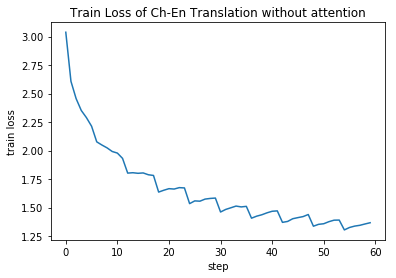

In [60]:
fig = plt.figure()
plt.plot(train_loss_history)
plt.xlabel('step')
plt.ylabel('train loss')
plt.title('Train Loss of Ch-En Translation without attention')
plt.show()
fig.savefig('train_loss_ch_10.png')

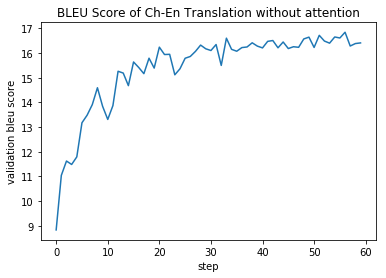

In [61]:

fig = plt.figure()
plt.plot(validation_score_history)
plt.xlabel('step')
plt.ylabel('validation bleu score')
plt.title('BLEU Score of Ch-En Translation without attention')
fig.savefig('val_score_ch_10.png')

plt.show()

In [62]:

encoder.load_state_dict(torch.load('zh_encoder_10.pt'))
decoder.load_state_dict(torch.load('zh_decoder_10.pt'))
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (dropout): Dropout(p=0.3)
  (embedding): Embedding(30004, 300)
  (gru): GRU(812, 512)
  (out): Linear(in_features=512, out_features=30004, bias=True)
  (softmax): LogSoftmax()
)

In [92]:
decoded_words,input_words, target_words, score = evaluate2(encoder, decoder, test_loader)

bleu score:  19.389888801081902


In [93]:
for i in range(len(decoded_words)):
    print('input: ', input_words[i])
    print('target: ', target_words[i])
    print('predict: ', decoded_words[i])
    print('-----------------------------------------------')
    print()

input:  ['丽贝卡', '布莱克', '莱克', '今天', '是', '周五', '周五', '玩乐', '派对', '在', '周五', '每个', '个人', '都', '期待', '着', '过', '周末', '周末', '周五', '周五', '玩乐', '在', '周五', '凯文', '如果', '没有', '这部', '视频', '你', '未必', '<UNK>', '想到', '我们', '将', '有', '接下', '接下来', '下来', '<EOS>']
target:  ['it', 's', 'friday', 'friday', '.', 'gotta', 'get', 'down', 'on', 'friday', '.', 'everybody', 's', 'looking', 'forward', 'to', 'the', 'weekend', 'weekend', '.', 'friday', 'friday', '.', '<UNK>', 'down', 'on', 'friday', '.', 'so', 'you', 'didn', 't', 'think', 'that', 'we', 'could', 'actually', 'have', 'this', '<EOS>']
predict:  ['friday', 'it', 's', 'friday', 'friday', 'friday', 'friday', 'friday', 'friday', 'friday', 'all', 'friday', 'on', 'friday', 'and', 'if', 'you', 'want', 'to', 'go', 'on', 'friday', 'and', 'don', 't', 'have', 'to', 'do', 'it', '.', '<EOS>']
-----------------------------------------------

input:  ['不过', '现在', '网络', '视频', '让', '它', '成真', '所以', '我们', '任何', '任何人', '何人', '都', '可以', '发挥', '创意', '做', '想', '做', '的', 

target:  ['because', 'of', 'course', 'this', 'is', 'a', 'photograph', 'that', 'you', 'can', 't', 'take', 'with', 'your', 'camera', '.', '<EOS>']
predict:  ['because', 'obviously', 'it', 's', 'a', 'camera', 'camera', 'but', 'you', 'can', 't', 'take', 'pictures', '.', '<EOS>']
-----------------------------------------------

input:  ['我', '想', '和', '大家', '谈谈', '众多', '电子', '医疗', '医疗保健', '保健', '项目', '失败', '的', '原因', '<EOS>']
target:  ['i', 'would', 'like', 'to', 'talk', 'to', 'you', 'about', 'why', 'many', 'e', 'health', 'projects', 'fail', '.', '<EOS>']
predict:  ['i', 'want', 'to', 'talk', 'about', 'you', 'about', 'the', 'health', 'of', 'healthcare', 'health', 'care', '.', '<EOS>']
-----------------------------------------------

input:  ['所以', '更', '注重', '的', '是', '捕捉', '一个', '灵感', '而', '不是', '捕捉', '一个', '真实', '实存', '存在', '的', '瞬间', '<EOS>']
target:  ['so', 'it', 's', 'more', 'about', 'capturing', 'an', 'idea', 'than', 'about', 'capturing', 'a', 'moment', 'really', '.', '<EOS>']
predict

predict:  ['if', 'you', 've', 'got', 'to', 'go', 'on', 'the', 'center', 'of', 'the', 'center', 'and', 'the', 'berlin', 'tony', 'in', 'paris', 'you', 've', 'got', 'to', 'do', 'something', 'like', 'this', 'and', 'you', 'have', 'to', 'have', 'different', 'things', 'that', 'have', 'been', '<EOS>']
-----------------------------------------------

input:  ['这里', '看起', '看起来', '起来', '它', '似乎', '是', '在', '等', '它', '的', '约会', '但', '它', '真正', '<UNK>', '等待', '的', '是', '一个', '可以', '将', '它', '被', '<UNK>', '<UNK>', '雪', '下', '的', '时候', '可以', '将', '它', '挖出', '挖出来', '出来', '的', '人', '因为', '<EOS>']
target:  ['here', 'it', 'kind', 'of', 'looks', 'like', 'he', 's', 'looking', 'for', 'a', 'date', 'but', 'what', 'he', 's', 'really', 'looking', 'for', 'is', 'for', 'someone', 'to', 'shovel', 'him', 'out', 'when', 'he', 'gets', 'snowed', 'in', 'because', 'he', 'knows', 'he', 's', 'not', 'very', 'good', '<EOS>']
predict:  ['it', 'looks', 'like', 'it', 's', 'going', 'to', 'be', 'a', 'helicopter', 'for', 'it', 'bu


input:  ['市民', '联通', '对', '这种', '问题', '有', '不同', '的', '处理', '<UNK>', '方式', '<EOS>']
target:  ['but', 'what', 'happens', 'with', 'citizens', 'connect', 'is', 'different', '.', '<EOS>']
predict:  ['citizens', 'citizens', 'to', 'a', 'different', 'way', 'of', 'dealing', '.', '<EOS>']
-----------------------------------------------

input:  ['将', '垃圾', '垃圾桶', '<UNK>', '走回', '回家', '<EOS>']
target:  ['turned', 'trashcan', 'on', 'its', 'side', '.', 'walked', 'home', '.', '<EOS>']
predict:  ['trash', 'it', 'back', '.', '<EOS>']
-----------------------------------------------

input:  ['这', '一次', '一个', '邻居', '看到', '了', '<EOS>']
target:  ['and', 'in', 'this', 'case', 'a', 'neighbor', 'saw', 'it', '.', '<EOS>']
predict:  ['and', 'this', 'neighborhood', 'once', 'seen', 'neighbors', '.', '<EOS>']
-----------------------------------------------

input:  ['Scott', '之前', '是', '人', '对', '人', '的', '交流', '<EOS>']
target:  ['so', 'scott', 'was', 'speaking', 'person', 'to', 'person', '.', '<EOS>']
predict:

predict:  ['and', 'in', 'this', 'case', 'there', 's', 'a', 'lot', 'of', 'different', 'organisms', 'that', 'are', 'working', 'together', 'with', 'the', 'genetic', 'cells', '.', '<EOS>']
-----------------------------------------------

input:  ['这个', '过程', '是', '自给', '自给自足', '自足', '并且', '变成', '我', '猜', '应该', '自我', '催化', '描述', '更合', '合适', '当事', '事物', '加快', '改变', '的', '速度', '<EOS>']
target:  ['the', 'process', 'is', 'feeding', 'on', 'itself', 'and', 'becoming', 'i', 'guess', '<UNK>', 'is', 'the', 'word', 'for', 'it', 'when', 'something', 'reinforces', 'its', 'rate', 'of', 'change', '.', '<EOS>']
predict:  ['and', 'this', 'process', 'is', 'becoming', 'and', 'i', 'think', 'it', 's', 'a', 'better', 'way', 'of', 'deciding', 'and', 'i', 'think', 'it', 's', 'possible', 'to', 'improve', 'the', 'speed', 'of', 'the', 'speed', '.', '<EOS>']
-----------------------------------------------

input:  ['这样', '这些', '交流', '致使', '群落', '的', '形成', '在', '某种', '某种意义', '意义', '上', '它们', '在', '同一', '一条', '船上', '了'

-----------------------------------------------

input:  ['但是', '它们', '能', '完成', '任务', '<EOS>']
target:  ['but', 'they', 'do', 'the', 'job', '.', '<EOS>']
predict:  ['but', 'they', 'can', 'do', 'it', '.', '<EOS>']
-----------------------------------------------

input:  ['它们', '很', '抽象', '奇怪', '<EOS>']
target:  ['they', 're', 'obscure', 'weird', 'programs', '.', '<EOS>']
predict:  ['they', 're', 'very', 'abstract', '.', '<EOS>']
-----------------------------------------------

input:  ['可能', '引入', '一些', '突变', '<EOS>']
target:  ['introduce', 'some', 'mutations', 'perhaps', '.', '<EOS>']
predict:  ['it', 'may', 'be', 'some', 'momentum', '.', '<EOS>']
-----------------------------------------------

input:  ['我们', '正在', '起飞', '<EOS>']
target:  ['we', 're', 'taking', 'off', '.', '<EOS>']
predict:  ['we', 're', 'going', 'to', 'go', 'on', 'the', 'right', '.', '<EOS>']
-----------------------------------------------

input:  ['再', '做', '一次', '<EOS>']
target:  ['score', 'them', 'again', '.', '

target:  ['today', 'there', 'are', '.', 'million', '.', '<EOS>']
predict:  ['today', 'there', 's', 'million', '.', '<EOS>']
-----------------------------------------------

input:  ['我', '永远', '<UNK>', '<UNK>', '<EOS>']
target:  ['i', 'never', 'will', 'forget', 'it', '.', '<EOS>']
predict:  ['i', 'never', 'never', 'forever', '.', '<EOS>']
-----------------------------------------------

input:  ['我', '这个', '伤心', '呀', '<EOS>']
target:  ['i', 'was', 'devastated', '.', '<EOS>']
predict:  ['i', 'was', 'sad', '.', '<EOS>']
-----------------------------------------------

input:  ['那时', '的', '人', '现在', '上', '了', '年纪', '来', '和', '我', '说', '史蒂文', '<UNK>', '先生', '你', '到处', '演讲', '你', '得', '告诉', '大家', '别说', '什么', '911', '以后', '是', '我们', '美国', '国有', '有史以来', '以来', '第一', '第一次', '一次', '对付', '恐怖', '恐怖主义', '主义', '<EOS>']
target:  ['and', 'these', 'older', 'people', 'come', 'up', 'to', 'me', 'now', 'and', 'they', 'say', 'quot', 'mr', '.', 'stevenson', 'you', 'give', 'talks', 'you', 'make', 'speeches', 

predict:  ['he', 'looked', 'at', 'me', 'and', 'he', 'said', 'quot', 'who', 'are', 'you', '?', 'quot', '<UNK>', '<EOS>']
-----------------------------------------------

input:  ['因为', '正是', '在', '这个', '<UNK>', '<UNK>', '我们', '真正', '地', '开始', '对于', '我们', '是', '什么', '什么样', '的', '人', '有', '了', '深入', '的', '理解', '<EOS>']
target:  ['because', 'it', 's', 'in', 'that', '<UNK>', 'that', 'we', 'actually', 'begin', 'to', 'understand', 'truly', 'profound', 'things', 'about', 'who', 'we', 'are', '.', '<EOS>']
predict:  ['because', 'it', 's', 'really', 'what', 'we', 're', 'beginning', 'to', 'see', 'what', 'we', 're', 'beginning', 'to', 'see', 'what', 'we', 're', 'beginning', 'to', 'understand', '.', '<EOS>']
-----------------------------------------------

input:  ['最后', '我', '决定', '天', '哪', '我', '得', '上', '<UNK>', '去', '做', '这个', '个案', '案子', '<EOS>']
target:  ['and', 'i', 'finally', 'decided', 'oh', 'gosh', 'i', 've', 'got', 'to', 'go', 'to', 'the', 'court', 'and', 'do', 'this', 'crazy', 'case', '.

-----------------------------------------------

input:  ['今天', '早上', '我', '和', '一个', '伟大', '的', 'DIY', '发明', '发明家', 'Dean', '<UNK>', '聊天', '我', '想要', '和', '大家', '分享', '我', '得到', '了', '他', '的', '允许', '他', '开发', '的', '技术', '叫做', '弹弓', '在座', '的', '一些', '朋友', '可能', '听说', '过', '它', '是', '<EOS>']
target:  ['and', 'the', 'conversation', 'i', 'had', 'with', 'dean', 'kamen', 'this', 'morning', 'one', 'of', 'the', 'great', 'diy', 'innovators', 'i', 'd', 'like', 'to', 'share', 'with', 'you', 'he', 'gave', 'me', 'permission', 'to', 'do', 'so', 'his', 'technology', 'called', 'slingshot', 'that', 'many', 'of', 'you', 'may', '<EOS>']
predict:  ['i', 'd', 'been', 'with', 'a', 'great', 'relationship', 'and', 'i', 'love', 'with', 'a', 'very', 'good', 'idea', 'and', 'i', 'want', 'to', 'tell', 'you', 'that', 'he', 'could', 'have', 'to', 'call', 'it', 'as', 'a', 'technology', 'and', 'a', 'technology', 'that', 'is', 'known', 'to', '<EOS>']
-----------------------------------------------

input:  ['上个', '上个

target:  ['it', 'came', 'out', 'of', 'the', 'university', 'of', 'washington', 'in', 'seattle', '.', '<EOS>']
predict:  ['it', 's', 'from', 'the', 'university', 'of', 'washington', 'from', 'washington', '.', '<EOS>']
-----------------------------------------------

input:  ['其', '折叠', '的', '方式', '决定', '了', '该', '氨基', '氨基酸', '的', '结构', '和', '功能', '<EOS>']
target:  ['and', 'how', 'it', 'folds', 'dictates', 'its', 'structure', 'and', 'its', 'functionality', '.', '<EOS>']
predict:  ['and', 'the', 'way', 'that', 'folds', 'determines', 'is', 'that', 'the', 'structure', 'of', 'the', 'structure', 'is', 'made', 'the', 'structure', 'of', 'the', 'amino', 'acids', '.', '<EOS>']
-----------------------------------------------

input:  ['他们', '将', '会', '消费', '什么', '他们', '的', '愿望', '是', '什么', '<EOS>']
target:  ['what', 'will', 'they', 'consume', '?', 'what', 'will', 'they', 'desire', '?', '<EOS>']
predict:  ['what', 'will', 'they', 'be', 'their', 'consumer', '?', '<EOS>']
-----------------------------

-----------------------------------------------

input:  ['但', '在', '接下', '接下来', '下来', '的', '两三', '两三天', '三天', '中', '她', '再也', '再也不会', '不会', '醒来', '的', '可能', '可能性', '越来', '越来越', '大', '<EOS>']
target:  ['and', 'over', 'the', 'next', 'two', 'or', 'three', 'days', 'it', 'was', 'clear', 'that', 'she', 'was', 'never', 'going', 'to', 'wake', 'up', '.', '<EOS>']
predict:  ['but', 'in', 'the', 'next', 'three', 'days', 'she', 'would', 'be', 'like', 'more', 'or', 'three', 'or', 'more', 'than', 'the', 'same', 'time', '.', '<EOS>']
-----------------------------------------------

input:  ['在', '接下', '接下来', '下来', '的', '八', '到', '九天', '里', '他们', '慢慢', '的', '接受', '了', '这件', '事实', '<EOS>']
target:  ['and', 'over', 'the', 'course', 'of', 'the', 'next', 'eight', 'or', 'nine', 'days', 'they', 'resigned', 'themselves', 'to', 'what', 'was', 'happening', '.', '<EOS>']
predict:  ['and', 'over', 'the', 'next', 'eight', 'they', 'were', 'intrigued', '.', '<EOS>']
-----------------------------------------------


target:  ['how', 'can', 'i', 'teach', 'them', 'about', 'what', 'i', 'did', 'so', 'that', 'they', 'don', 't', 'do', 'the', 'same', 'thing', '?', '<EOS>']
predict:  ['how', 'do', 'i', 'teach', 'them', '?', 'i', 'hadn', 't', 'going', 'to', 'take', 'my', 'whole', 'story', '.', '<EOS>']
-----------------------------------------------

input:  ['这', '几乎', '就', '像', '免疫', '免疫系统', '系统', '的', '自我', '反应', '像', '抗体', '一般', '开始', '攻击', '那个', '不一', '一样', '的', '人', '<EOS>']
target:  ['and', 'it', 's', 'almost', 'like', 'an', 'ideological', 'reaction', 'like', 'the', 'antibodies', 'begin', 'to', 'attack', 'that', 'person', '.', '<EOS>']
predict:  ['it', 's', 'almost', 'like', 'the', 'immune', 'response', 'like', 'the', 'immune', 'response', 'that', 's', 'the', 'immune', 'response', 'that', 's', 'beginning', 'to', 'be', 'like', '.', '<EOS>']
-----------------------------------------------

input:  ['我', '仍然', '不知', '各位', '如何', '看待', '我', '但', '我', '想', '我', '对此', '可以', '接受', '<EOS>']
target:  ['i', 's